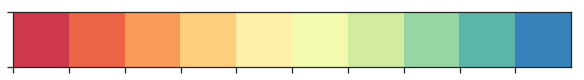

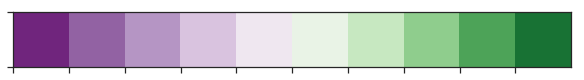

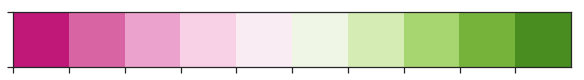

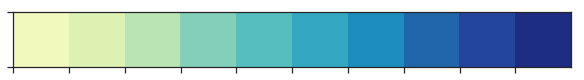

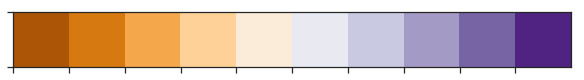

In [336]:
%matplotlib inline
import ast
from bs4 import BeautifulSoup
from config import api_key_tmdb
import csv
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import re
import requests
from scipy import stats
import seaborn as sns
sns.palplot(sns.color_palette("Spectral", 10))
sns.palplot(sns.color_palette("PRGn", 10))
sns.palplot(sns.color_palette("PiYG", 10))
sns.palplot(sns.color_palette("YlGnBu", 10))
sns.palplot(sns.color_palette("PuOr", 10))
import sqlite3
from sqlite3 import Error
import time
from wordcloud import WordCloud, STOPWORDS

In [323]:
# Importing the IMDB movies file
data = "/Users/florencialeoni/Documents/flatironDS/Mod_1_FP/mod1_movies/imdb_movies_data.csv"
use_cols = ["imdb_id", "imdb_score", "meta_score"]

# Using pandas.read_csv method to load the file
imdb_df = pd.read_csv(data, usecols = use_cols)
imdb_df = imdb_df.set_index("imdb_id")

In [324]:
# Replace missing data in the "imdb_score" and "meta_score" columns with NumPy NaN values
imdb_df["imdb_score"] = imdb_df["imdb_score"].replace(" ", np.nan)
imdb_df["meta_score"] = imdb_df["meta_score"].replace(" ", np.nan)

In [325]:
# Importing the TMDB Movies file
data = "/Users/florencialeoni/Documents/flatironDS/Mod_1_FP/mod1_movies/tmdb_movies_cast_df.csv"

# Using pandas.read_csv method to load the file
tmdb_df = pd.read_csv(data, lineterminator='\n')
tmdb_df = tmdb_df.set_index("id")
tmdb_df = tmdb_df.merge(imdb_df, how = "left", on = "imdb_id")

In [326]:
# Using pandas.to_numeric to coerce the "id", "budget" and "revenue" columns into numbers
tmdb_df["budget"] = pd.to_numeric(tmdb_df["budget"], downcast = "integer", errors = "coerce")
tmdb_df["revenue"] = pd.to_numeric(tmdb_df["revenue"], downcast = "integer", errors = "coerce")

# Lambda function to strip and split "release_date" string values
f = lambda x: str(x).strip().split('-')[0] if x != np.nan else np.nan

# Creating a new column, "year", and assigninf the value of "release_date" 
# After applying the lambda function through map
tmdb_df["year"] = tmdb_df["release_date"].map(f)

# Coerce the "year" column to integers
tmdb_df["year"] = pd.to_numeric(tmdb_df["year"], errors = "coerce")

# Convert "release_date" column to datetime format
tmdb_df["release_date"] = pd.to_datetime(tmdb_df["release_date"])

tmdb_df["title"] = tmdb_df["title"].astype("str")

tmdb_df["overview"] = tmdb_df["overview"].astype("str")

In [327]:
# Divide "release_date" column in months
tmdb_df["month_of_year"] = tmdb_df["release_date"].dt.month_name()

# Divide "release_date" column in months
tmdb_df["day_of_week"] = tmdb_df["release_date"].dt.day_name()

In [328]:
tmdb_df = tmdb_df.drop(["release_date"], axis=1)

In [329]:
tmdb_df_revenue = tmdb_df[tmdb_df["revenue"].notnull()][["title", "budget", "revenue", "runtime", "year", 
                        "month_of_year", "day_of_week", "popularity", "imdb_score", "meta_score"]].sort_values("popularity", ascending = False)

tmdb_df_revenue = tmdb_df_revenue.dropna(subset=["budget"])


In [94]:
# Function to create a new SQLite3 Database
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    finally:
        conn.close()

In [95]:
# Use create_connection function to create Database
create_connection("/Users/florencialeoni/Documents/flatironDS/Mod_1_FP/mod1_movies/movies.db")

In [101]:
# Create a connection object using the connect function 
# To establish a connection with "movies.db"
connection = sqlite3.connect("movies.db")
# Create a cursor object by calling the cursor method
cursor = connection.cursor()

In [97]:
# Write records stored in the imdb_df DataFrame to a SQL database
imdb_df.to_sql("imdb_movies", con = connection)

In [98]:
# Write records stored in the tmdb_df DataFrame to a SQL database
tmdb_df.to_sql("tmdb_movies", con = connection)

In [214]:
combined_df = pd.read_sql_query('''
SELECT
    id,
    title, 
    belongs_to_collection, 
    budget, 
    genres,
    overview, 
    revenue, 
    tagline, 
    director_name,
    leading_actor_name,
    supporting_actor_name,
    vote_average, 
    vote_count, 
    runtime, 
    popularity, 
    production_companies,
    year,
    month_of_year,
    day_of_week,
    tmdb_movies.imdb_id AS tmdb_imdb_id,
    imdb_movies.imdb_id AS imdb_id,
    imdb_score
    meta_score
FROM
    tmdb_movies
    INNER JOIN imdb_movies ON tmdb_movies.imdb_id = imdb_movies.imdb_id;''', connection)

In [215]:
pd.read_sql_query('''SELECT title, MAX(popularity) FROM tmdb_movies''', connection)

,title,MAX(popularity)
0,Bumblebee,226.241


In [216]:
pd.read_sql_query('''SELECT title, MAX(revenue) FROM tmdb_movies''', connection)

,title,MAX(revenue)
0,Avatar,2.787965e+09


In [217]:
pd.read_sql_query('''SELECT title, MAX(budget) FROM tmdb_movies''', connection)

,title,MAX(budget)
0,Justice League,500000000.0


In [218]:
pd.read_sql_query('''SELECT title, MIN(budget) FROM tmdb_movies''', connection)

,title,MIN(budget)
0,The Hunted,1.0


In [340]:
pd.read_sql_query('''SELECT title, MIN(popularity) FROM tmdb_movies''', connection)

,title,MIN(popularity)
0,Resident Evil: Afterlife,0.6


In [330]:
tmdb_runtime = tmdb_df[tmdb_df["runtime"] > 0][["runtime", "year", "popularity", "imdb_score", 
                                                "meta_score", "budget", "revenue"]].sort_values("popularity", ascending = False)
tmdb_runtime

,runtime,year,popularity,imdb_score,meta_score,budget,revenue
3,114.0,2018.0,226.241,7.0,66,135000000.0,4.203613e+08
22,107.0,2018.0,148.786,6.6,NaN,NaN,NaN
2,149.0,2018.0,129.988,8.5,68,300000000.0,2.046240e+09
1,144.0,2018.0,129.402,7.2,NaN,160000000.0,1.143689e+09
0,117.0,2018.0,115.129,8.5,87,90000000.0,3.628236e+08
6,129.0,2018.0,70.197,6.2,NaN,100000000.0,1.042365e+08
17,119.0,2018.0,65.320,7.1,70,140000000.0,6.223796e+08
16,143.0,2012.0,60.391,8.1,69,220000000.0,1.519558e+09
7,134.0,2018.0,60.071,7.3,88,200000000.0,1.346739e+09
10,121.0,2014.0,58.090,8.1,76,170000000.0,7.733286e+08


In [286]:
tmdb_df_rel = tmdb_df[tmdb_df["imdb_id"].notnull()][["title", "runtime", "year", 
                        "month_of_year", "day_of_week", "popularity"]]

tmdb_df_revenue_rel = tmdb_df[tmdb_df["revenue"].notnull()][["title", "budget", "revenue", "runtime", "year", 
                        "month_of_year", "day_of_week", "popularity"]]

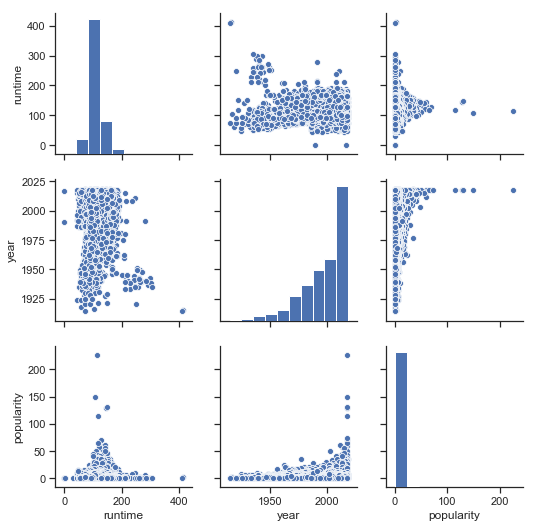

In [312]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(tmdb_df_rel)

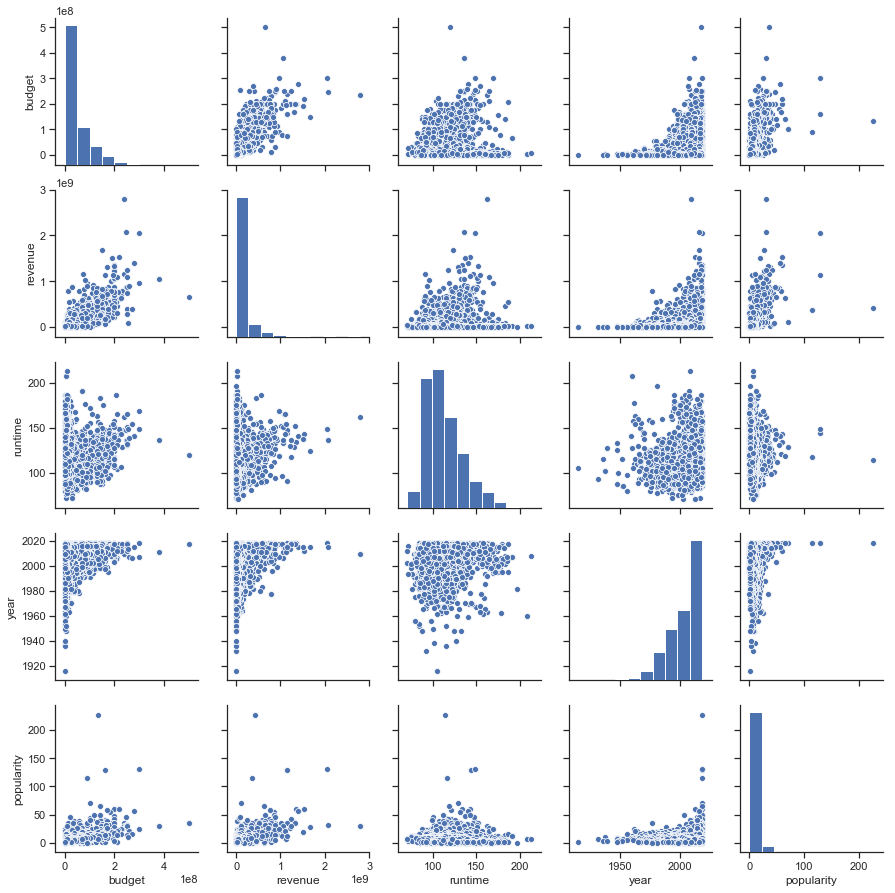

In [308]:
sns.pairplot(tmdb_df_revenue_rel)

In [285]:
less_popular = tmdb_df[tmdb_df["popularity"].notnull()][["title", "tagline", 
                        "popularity", "year", "overview", "director_name", 
                            "leading_actor_name", "supporting_actor_name", "budget"]].sort_values("popularity").head(100)

In [276]:
less_popular

,title,tagline,popularity,year,overview,director_name,leading_actor_name,supporting_actor_name,budget
3430,Double Trouble,NaN,0.6,2017.0,Firangi is a Hindi movie starring Kapil Sharma...,Enzo Barboni,Terence Hill,Bud Spencer,NaN
7313,Yeh Mohabbat Hai,NaN,0.6,2017.0,A young couple who are so poor that they have ...,NaN,NaN,NaN,NaN
5052,Firepower,NaN,0.6,2016.0,A young girl tormented by the tragedies of her...,NaN,NaN,NaN,NaN
7310,Krishan Avtaar,Kingdom of the King,0.6,2016.0,Rajan Zachariah is a Circle Inspector of Polic...,NaN,NaN,NaN,NaN
5056,Around the World Under the Sea,The Battle For Life,0.6,2000.0,The son of Police Inspector Veer Chauhan requi...,Andrew Marton,Lloyd Bridges,Brian Kelly,NaN
7302,Big and Little Wong Tin Bar,NaN,0.6,2017.0,Tim Tucker (Dylan Bruce) was a star forward wh...,Jim-Yuen Yu,Jackie Chan,Sammo Hung,NaN
7298,Gamera vs. Viras,NaN,0.6,2011.0,A former guerrilla is reluctantly drawn into t...,Noriaki Yuasa,NaN,Tôru Takatsuka,NaN
7296,Bitcoin Heist,What if it was your sister?,0.6,1976.0,When his sister Betsy packs up and leaves the ...,NaN,NaN,NaN,NaN
7295,The Legend of Suriyothai,NaN,0.6,2004.0,"Set in Post World War II Britain, chronicles t...",Chatrichalerm Yukol,M.L. Piyapas Bhirombhakdi,Sarunyu Wongkrachang,NaN
7294,Hunter,NaN,0.6,2007.0,"The movie tells the story of Arjun, a young at...",NaN,NaN,NaN,618000.0


In [341]:
less_popular_title = pd.Series(' '.join(less_popular["title"]).lower().split()).value_counts()[:200]

In [303]:
less_popular_overview = pd.Series(' '.join(less_popular["overview"]).lower().split()).value_counts()[:200]

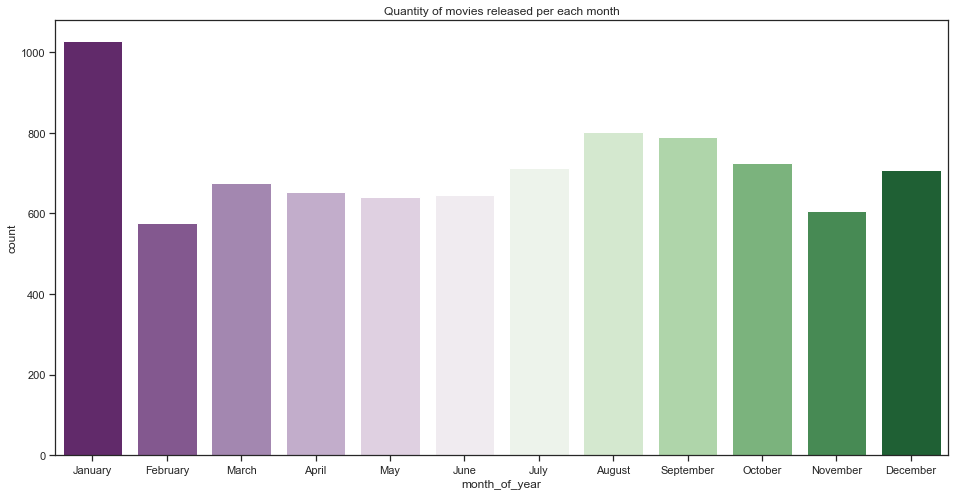

In [317]:
plt.figure(figsize=(16,8))
plt.title("Quantity of movies released per each month")
sns.countplot(x = "month_of_year", data = tmdb_df, palette = "PRGn", order = ["January", "February", 
                                                                              "March", "April", "May",
                                                                             "June", "July", "August",
                                                                             "September", "October",
                                                                             "November", "December"])

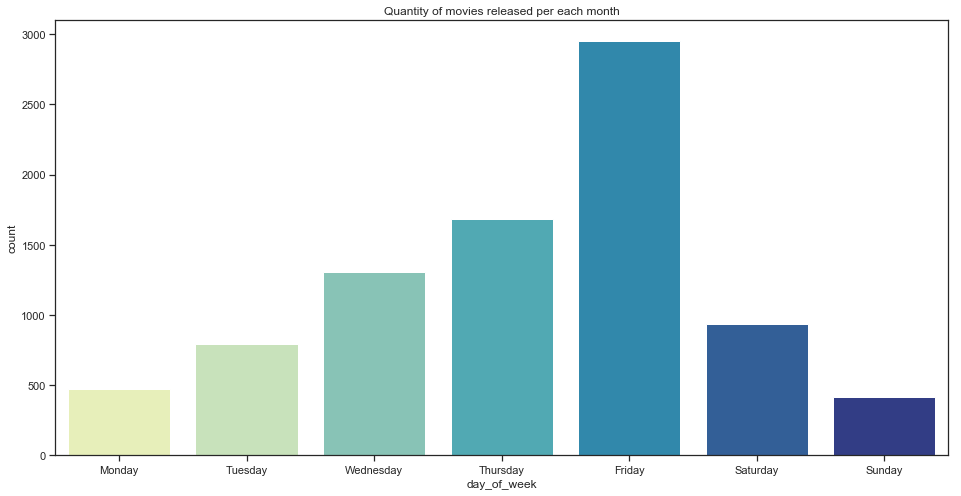

In [339]:
plt.figure(figsize=(16,8))
plt.title("Quantity of movies released per each month")
sns.countplot(x = "day_of_week", data = tmdb_df, palette = "YlGnBu", order = ["Monday", "Tuesday", 
                                                                              "Wednesday", "Thursday", "Friday",
                                                                             "Saturday", "Sunday"])

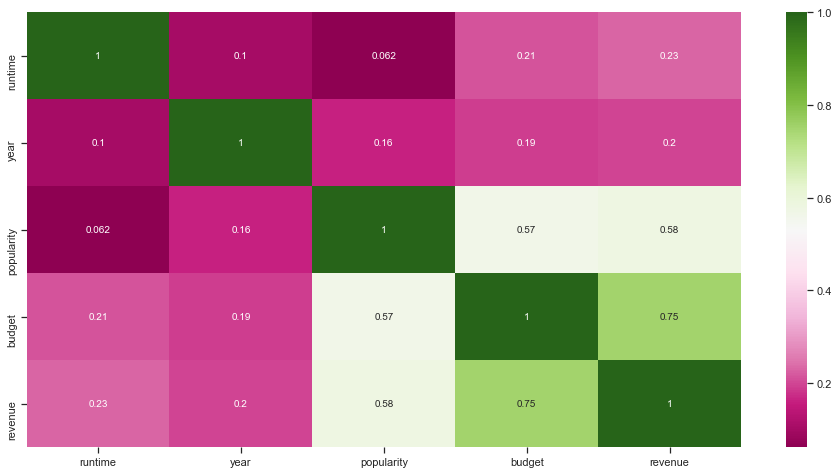

In [338]:
plt.figure(figsize = (16, 8))
sns.heatmap(tmdb_runtime.corr(), annot = True, cmap = "PiYG")

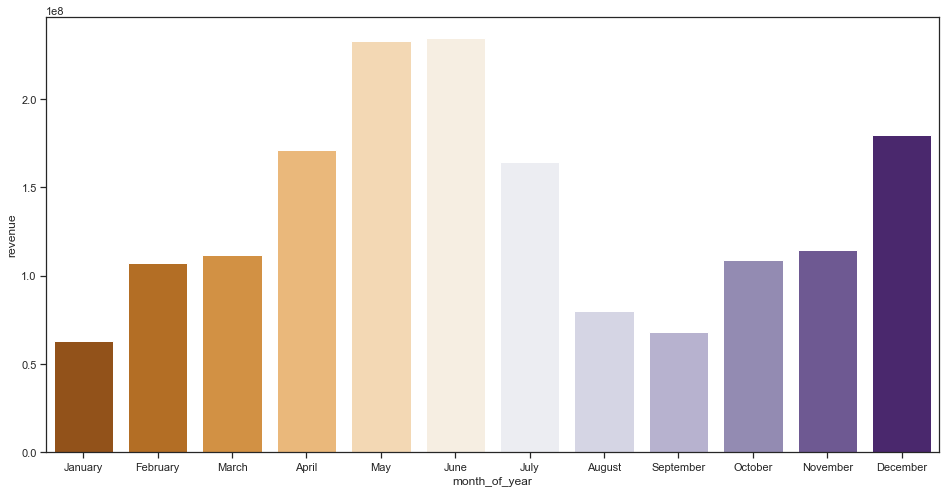

In [375]:
month_df = tmdb_df_revenue[tmdb_df_revenue["month_of_year"].notnull()][["revenue", "month_of_year"]]
avg_rev_month = month_df.groupby("month_of_year").mean()
avg_rev_month.reset_index(inplace = True)
plt.figure(figsize = (16, 8))
sns.barplot(x = "month_of_year", y = "revenue", palette = "PuOr", data = avg_rev_month, order = ["January", "February", 
                                                                              "March", "April", "May",
                                                                             "June", "July", "August",
                                                                             "September", "October",
                                                                             "November", "December"])

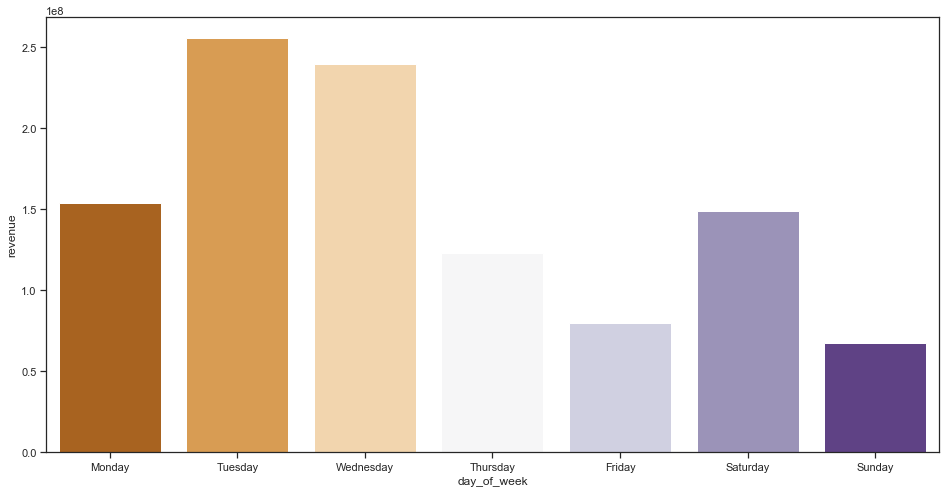

In [380]:
day_df = tmdb_df_revenue[tmdb_df_revenue["day_of_week"].notnull()][["revenue", "day_of_week"]]
avg_rev_day = day_df.groupby("day_of_week").mean()
avg_rev_day.reset_index(inplace = True)
plt.figure(figsize = (16, 8))
sns.barplot(x = "day_of_week", y = "revenue", palette = "PuOr", data = avg_rev_day, order = ["Monday", "Tuesday", 
                                                                              "Wednesday", "Thursday", "Friday",
                                                                             "Saturday", "Sunday"])